In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from os import walk
import sklearn
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
# Seaborn library for bar chart
import seaborn as sns

# Libraries for TensorFlow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras import models, layers
from keras.preprocessing.image import ImageDataGenerator

# Library for Transfer Learning
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

img_width=224
img_height=224

print("Importing libraries completed.")

Importing libraries completed.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_list = os.listdir("/content/drive/My Drive/chest_xray/test/NORMAL")
test_x = []
test_y = []
for img_name in image_list:
    # Loading images
    img=load_img("/content/drive/My Drive/chest_xray/test/NORMAL/"+img_name,target_size=(img_width,img_height))
            # Converting to arrary
    img=img_to_array(img)
        
    # Transfer Learning: this is to apply preprocess of VGG16 model to our images before passing it to VGG16
    img=preprocess_input(img) #  Optional step
        
    # Appending the arrarys
    test_x.append(img) # appending image array
    test_y.append(0)

image_list = os.listdir("/content/drive/My Drive/chest_xray/test/PNEUMONIA")

for img_name in image_list:
    # Loading images
    img=load_img("/content/drive/My Drive/chest_xray/test/PNEUMONIA/"+img_name,target_size=(img_width,img_height))
            # Converting to arrary
    img=img_to_array(img)
        
    # Transfer Learning: this is to apply preprocess of VGG16 model to our images before passing it to VGG16
    img=preprocess_input(img) #  Optional step
        
    # Appending the arrarys
    test_x.append(img) # appending image array
    test_y.append(1)

In [ ]:
train_dir = "/content/drive/My Drive/chest_xray/train"
test_dir = "/content/drive/My Drive/chest_xray/test"
val_dir = "/content/drive/My Drive/chest_xray/val"

image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=6, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(img_width, img_height))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(img_width, img_height))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(img_width, img_height))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
print(np.unique(train.classes, return_counts=True))

(array([0, 1], dtype=int32), array([1341, 3875]))


In [ ]:
print("Summary of default VGG16 model.\n")

# we are using VGG16 for transfer learnin here. So we have imported it
from tensorflow.keras.applications import VGG16

# initializing model with weights='imagenet'i.e. we are carring its original weights
model_vgg16=VGG16(weights='imagenet')

# display the summary to see the properties of the model
model_vgg16.summary()

Summary of default VGG16 model.

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D) 

In [ ]:
# let us prepare our input_layer to pass our image size. default is (224,224,3). we will change it to (224,224,3)

input_layer=layers.Input(shape=(img_width,img_height,3))
model_vgg16=VGG16(weights='imagenet',input_tensor=input_layer,include_top=False)

# See the summary of the model with our properties.
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# we will freez all the layers except the last layer

# we are making all the layers intrainable except the last layer
print("We are making all the layers intrainable except the last layer. \n")
for layer in model_vgg16.layers[:-1]:
    layer.trainable=False
model_vgg16.summary()

We are making all the layers intrainable except the last layer. 

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                             

In [ ]:
print("Summary of Custom VGG16 model.\n")

last_layer=model_vgg16.output # we are taking last layer of the model

# Add flatten layer: we are extending Neural Network by adding flattn layer
x = Flatten()(last_layer)
x = Dense(256, activation='relu',kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu',kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Add dense layer to the final output layer
output_layer=Dense(1,activation='sigmoid')(x)

# Creating modle with input and output layer
model=models.Model(inputs=input_layer,outputs=output_layer)

# Summarize the model
model.summary()

Summary of Custom VGG16 model.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  

In [ ]:
# Compiling Model

model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0001),metrics=['accuracy',Precision(name='precision'),Recall(name='recall')])

print("Model compilation completed.")

Model compilation completed.


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
epochs = 50
batch_size = 64
class_weight = {0: 0.75,
                1: 0.25}
history = model.fit(train,epochs=epochs,batch_size=batch_size,verbose=True,validation_data=validation,class_weight=class_weight)
# history = model.fit(xtrain,ytrain,epochs=epochs,batch_size=batch_size,verbose=True,validation_data=(xtest,ytest))

print("Fitting the model completed.")

Epoch 1/50
652/652 [==============================] - 133s 197ms/step - loss: 3.2406 - accuracy: 0.8229 - precision: 0.9659 - recall: 0.7894 - val_loss: 1.7714 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/50
652/652 [==============================] - 124s 190ms/step - loss: 1.2424 - accuracy: 0.8880 - precision: 0.9768 - recall: 0.8699 - val_loss: 1.0230 - val_accuracy: 0.8750 - val_precision: 0.8750 - val_recall: 0.8750
Epoch 3/50
652/652 [==============================] - 126s 193ms/step - loss: 0.7558 - accuracy: 0.8982 - precision: 0.9745 - recall: 0.8862 - val_loss: 0.6754 - val_accuracy: 0.9375 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 4/50
652/652 [==============================] - 125s 191ms/step - loss: 0.5251 - accuracy: 0.8988 - precision: 0.9689 - recall: 0.8924 - val_loss: 1.0013 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 5/50
652/652 [==============================] - 125s 192ms/step - loss: 0.4081 - a

In [ ]:
def plot_history(history, acc_line=None, title=None, acc_lim=[0.5,1.0]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    if title:
        fig.suptitle(title, fontsize=16)
    
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    if acc_line:
        ax1.axhline(y=acc_line, linewidth=2, linestyle='dashed', color='lightgrey')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    #ax1.set_yticks(np.arange(0., 1.1, .1))
    ax1.set_ylim(acc_lim)
    ax1.legend(['Train', 'Validation'])
    ax1.grid(b=True, which='major', color='lightgrey', linestyle='dotted')
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim([0, 5])
    ax2.legend(['Train', 'Validation'])
    ax2.grid(b=True, which='major', color='lightgrey', linestyle='dotted')

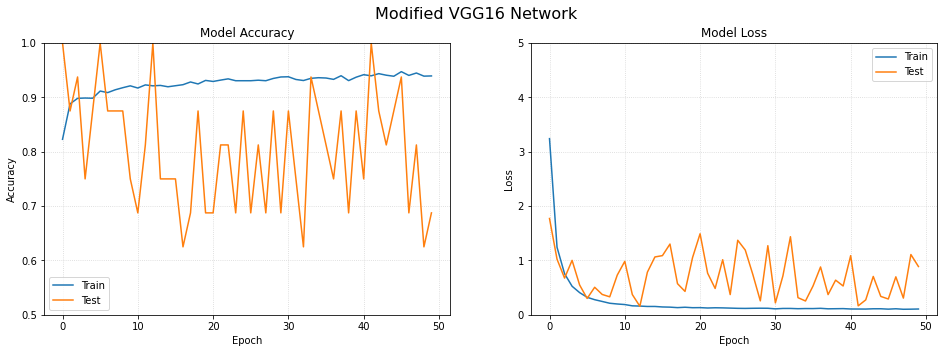

In [ ]:
plot_history(history,  title='Modified VGG16 Network')

In [ ]:
y_test_pred = model.predict(test)

624/624 [==============================] - 14s 23ms/step


In [ ]:
for i in y_test_pred:
  if i[0] < 0.5:
    i[0] = int(0)
  else:
    i[0] = int(1)


array([[0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],

In [ ]:
test_y = np.array(test_y).reshape(624, 1)

              precision    recall  f1-score   support

           0       0.98      0.52      0.68       234
           1       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.77       624
weighted avg       0.85      0.81      0.80       624



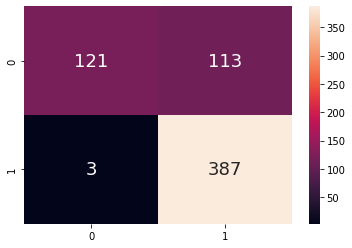

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
print(classification_report(test_y, y_test_pred))

# Plot the two-way Confusion Matrix
sns.heatmap(confusion_matrix(test_y, y_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})